In [ ]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [ ]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield -= leadfield.mean(axis=0)
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 111.41it/s]

Using control points [1.00230562e-10 4.95088704e-10 3.62415365e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


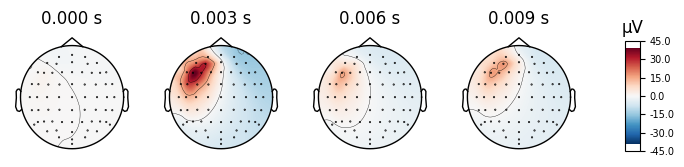

In [1034]:
%matplotlib qt

# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=1e99)
settings = dict(number_of_sources=2, extents=(25, 26), duration_of_trial=0.01, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
y -= y.mean(axis=0)
x = stc.data

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
# plt.figure()
evoked.plot_topomap()

# Algo

## Helper functions

In [ ]:
def thresholding(x, k):
    if type(x) == list:
        x = np.array(x)
    highest_idc = np.argsort(abs(x))[-k:]
    # print(highest_idc)
    x_new = np.zeros(len(x))
    x_new[highest_idc] = x[highest_idc]
    return x_new

def calc_residual_variance(M_hat, M):
        return 100 * np.sum( (M-M_hat)**2 ) / np.sum(M**2)

def euclidean_distance(A, B):
    ''' Euclidean Distance between two points.'''
    return np.sqrt(np.sum((A-B)**2))
def calc_area_tri(AB, AC, CB):
    ''' Calculates area of a triangle given the length of each side.'''
    s = (AB + AC + CB) / 2
    area = (s*(s-AB)*(s-AC)*(s-CB)) ** 0.5
    return area
def find_corner(source_power, residual):
    ''' Find the corner of the l-curve given by plotting regularization
    levels (r_vals) against norms of the inverse solutions (l2_norms).

    Parameters
    ----------
    r_vals : list
        Levels of regularization
    l2_norms : list
        L2 norms of the inverse solutions per level of regularization.
    
    Return
    ------
    idx : int
        Index at which the L-Curve has its corner.

    
    '''
    
    # Normalize l2 norms

    A = np.array([residual[0], source_power[0]])
    C = np.array([residual[-1], source_power[-1]])
    areas = []
    for j in range(1, len(source_power)-1):
        B = np.array([residual[j], source_power[j]])
        AB = euclidean_distance(A, B)
        AC = euclidean_distance(A, C)
        CB = euclidean_distance(C, B)
        area = abs(calc_area_tri(AB, AC, CB))
        areas.append(area)
    if len(areas) > 0:
        idx = np.argmax(areas)+1
    else:
        idx = 0
    return idx

## Orthogonal Matching Pursuit

In [727]:
K = 1
max_iter = n_chans
x_hat = np.zeros((n_dipoles, ))
omega = np.array([])
y -= y.mean(axis=0)
r = deepcopy(y[:, 0])
leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)
y_hat = leadfield@x_hat
y_hat -= y_hat.mean()
residuals = np.array([np.linalg.norm(y[:, 0] - y_hat), ])
source_norms = np.array([0,])
unexplained_variance = np.array([calc_residual_variance(np.zeros(y.shape), y),])

fig, ax = plt.subplots()
im, _ = mne.viz.plot_topomap(y[:, 0], info, axes=ax)
ax.set_title("Input")
plt.colorbar(im)

x_hats = [deepcopy(x_hat), ]
for i in range(max_iter):
    b = leadfield.T @ r
    b_corr = leadfield_norm.T @ (r / np.linalg.norm(r))
    if abs(b_corr).max() < 0.5:
        print(abs(b_corr).max())
        break
    print(b_corr.min(), b_corr.max())
    b_thresh = thresholding(b, K)
    omega = np.unique(np.append(omega, np.where(b_thresh!=0)[0]))  # non-zero idc
    omega = omega.astype(int)
    print(omega)
    # print(omega)
    # x_hat = np.zeros((n_dipoles,))
    x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @y[:, 0]
    # x_hat[omega] = np.linalg.pinv(leadfield)[omega] @ y[:, 0]


    y_hat = leadfield@x_hat
    y_hat -= y_hat.mean()

    fig, ax = plt.subplots()
    im, _ = mne.viz.plot_topomap(y_hat, info, axes=ax)
    ax.set_title(f"Iter {i}")
    plt.colorbar(im)

    
    r = y[:, 0] - y_hat

    fig, ax = plt.subplots()
    im, _ = mne.viz.plot_topomap(r, info, axes=ax)
    ax.set_title(f"Iter {i} Residual")
    plt.colorbar(im)

    x_hats.append(deepcopy(x_hat))

    
    residuals = np.append(residuals, np.linalg.norm(r))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(y_hat, y[:, 0]))
    if unexplained_variance[-1] < 0.1 or residuals[-1] > residuals[-2]:
        print(i, " iterations")
        break
    

# iters = np.arange(len(residuals)).astype(float)
# corner_idx = find_corner(iters[1:], unexplained_variance[1:])+1
# x_hat = x_hats[corner_idx]


# plt.figure()
# plt.plot(iters, unexplained_variance, '*k')
# plt.xlabel("iter")
# plt.ylabel("EEG unexplained_variance")
# plt.plot(iters[corner_idx], unexplained_variance[corner_idx], 'or')

-0.9679279913773209 0.9056962771006295
[884]
-0.7734770550066488 0.6849177402965468
[497 884]
0.3906060718549727


## CoSaMP

In [ ]:
K = 3
max_iter = n_chans
x_hat = np.zeros((n_dipoles, ))
b = np.zeros((n_dipoles, ))

omega = np.array([])
r = deepcopy(y[:, 0])
y-=y.mean(axis=0)
leadfield -= leadfield.mean(axis=0)
leadfield_norm = leadfield / leadfield.std(axis=0)
leadfield_pinv = np.linalg.pinv(leadfield)


residuals = np.array([np.linalg.norm(y[:, 0] - leadfield@x_hat), ])
source_norms = np.array([0,])
x_hats = [deepcopy(x_hat), ]
for i in range(1, max_iter+1):
    e = leadfield_norm.T @ r
    e_thresh = thresholding(e, 2*K)
    omega = np.where(e_thresh!=0)[0]
    old_activations = np.where(x_hats[i-1]!=0)[0]
    print(len(old_activations), len(omega))

    T = np.unique(np.concatenate([omega, old_activations]))
    print(T)
    leadfield_pinv = np.linalg.pinv(leadfield[:, T])
    b[T] = leadfield_pinv @ y[:, 0]
    x_hat = thresholding(b, K)

    y_hat = leadfield@x_hat
    y_hat -= y_hat.mean()
    r = y[:, 0] - y_hat
    
    residuals = np.append(residuals, np.linalg.norm(r))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    x_hats.append(deepcopy(x_hat))
    if residuals[-1] == residuals[-2]:
        break


    
corner_idx = find_corner(source_norms, residuals)
x_hat = x_hats[corner_idx]


# plt.figure()
# plt.plot(source_norms, residuals, '*k')
# plt.xlabel("Source Power")
# plt.ylabel("EEG Residual")
# plt.plot(source_norms[corner_idx], residuals[corner_idx], 'or')
# plt.title(f"Idx {corner_idx}")

# Simultaneous CoSaMP

In [ ]:
K = 10
max_iter = n_chans
n_time = y.shape[1]
x_hat = np.zeros((n_dipoles, n_time))
b = np.zeros((n_dipoles, ))

omega = np.array([])
r = deepcopy(y)
y-=y.mean(axis=0)
leadfield -= leadfield.mean(axis=0)
leadfield_norm = leadfield / leadfield.std(axis=0)
leadfield_pinv = np.linalg.pinv(leadfield)


residuals = np.array([np.linalg.norm(y - leadfield@x_hat), ])
source_norms = np.array([0,])
x_hats = [deepcopy(x_hat), ]
for i in range(1, max_iter+1):
    e = np.linalg.norm(leadfield_norm.T @ r, axis=1)
    e_thresh = thresholding(e, 2*K)
    omega = np.where(e_thresh!=0)[0]
    old_activations = np.where(np.linalg.norm(x_hats[i-1], axis=1)!=0)[0]
    print(len(old_activations), len(omega))

    T = np.unique(np.concatenate([omega, old_activations]))
    print(T)
    leadfield_pinv = np.linalg.pinv(leadfield[:, T])
    b[T] = np.linalg.norm(leadfield_pinv @ y, axis=1)
    new_set = np.where(thresholding(b, K)!=0)[0]
    print(len(new_set))
    x_hat = np.zeros((n_dipoles, n_time))
    x_hat[new_set, :] = np.linalg.pinv(leadfield[:, new_set]) @ y

    y_hat = leadfield@x_hat
    y_hat -= y_hat.mean(axis=0)
    r = y - y_hat
    
    residuals = np.append(residuals, np.linalg.norm(r))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    x_hats.append(deepcopy(x_hat))
    if residuals[-1] > residuals[-2]:
        break


    
# corner_idx = find_corner(source_norms, residuals)
# x_hat = x_hats[corner_idx]


# plt.figure()
# plt.plot(source_norms, residuals, '*k')
# plt.xlabel("Source Power")
# plt.ylabel("EEG Residual")
# plt.plot(source_norms[corner_idx], residuals[corner_idx], 'or')
# plt.title(f"Idx {corner_idx}")

# Simultaneous Orthogonal Matching Pursuit

In [ ]:
n_time = y.shape[1]
max_iter = n_chans
leadfield_pinv = np.linalg.pinv(leadfield)
x_hat = np.zeros((n_dipoles, n_time))
x_hats = [deepcopy(x_hat)]
residuals = np.array([np.linalg.norm(y - leadfield@x_hat), ])
unexplained_variance = np.array([calc_residual_variance(y, leadfield@x_hat),])
source_norms = np.array([0,])

R = deepcopy(y)
omega = np.array([])
q = 1
for i in range(max_iter):
    b_n = np.linalg.norm(leadfield.T@R, axis=1, ord=q)

    # if len(omega)>0:
    #     b_n[omega] = 0

    b_thresh = thresholding(b_n, 1)
    omega = np.append(omega, np.where(b_thresh!=0)[0])  # non-zero idc
    omega = np.unique(omega.astype(int))
    leadfield_pinv = np.linalg.pinv(leadfield[:, omega])
    x_hat[omega] = leadfield_pinv @ y
    R = y - leadfield@x_hat
    
    residuals = np.append(residuals, np.linalg.norm(R))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(y, leadfield@x_hat))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    x_hats.append( deepcopy(x_hat) )

unexplained_variance[0] = unexplained_variance[1]
iters = np.arange(len(residuals))
corner_idx = find_corner(residuals, iters)
x_hat = x_hats[corner_idx]

plt.figure()
plt.plot(iters, residuals, "*k")
plt.plot(iters[corner_idx], residuals[corner_idx], "or")
plt.xlabel("Iteration No.")
plt.ylabel("Residual")
plt.title(corner_idx)

In [ ]:

plt.figure()
plt.plot(iters, residuals, "*k")
plt.plot(iters[corner_idx], residuals[corner_idx], "or")
plt.xlabel("Iteration No.")
plt.ylabel("Residual")
plt.title(corner_idx)

# Iterative Hard Thresholding

In [ ]:
K = 10
lam = 1e-8

x_hat = np.zeros(n_dipoles)
y_hat = leadfield @ x_hat
y_hat -= y_hat.mean(axis=0)

for _ in range(100):
    x_hat = thresholding( x_hat + lam * leadfield.T @ (y[:, 0] - y_hat), K)
    y_hat = leadfield @ x_hat
    y_hat -= y_hat.mean()
    r = np.linalg.norm(y[:, 0] - y_hat)
    # print(np.linalg.norm(x_hat), r)

# Iterative Soft Thresholding

In [238]:
K = 10
mu = 0.9
theta = 1e-9

def soft_thresh(x, theta):
    x = np.sign(x) * np.clip(np.abs(x) - theta, a_min=0, a_max=None)
    x[np.abs(x)<theta] = 0
    return x

x_hat = np.zeros(n_dipoles)
y_hat = leadfield @ x_hat
y_hat -= y_hat.mean(axis=0)
r = deepcopy(y[:, 0])
for _ in range(100):
    # x_hat = soft_thresh( x_hat + leadfield.T @ (r), theta)
    x_hat = soft_thresh( x_hat + np.linalg.pinv(leadfield) @ r, theta)
    # print(abs(x_hat).max())
    
    theta *= mu

    y_hat = leadfield @ x_hat
    y_hat -= y_hat.mean()
    r = y[:, 0] - y_hat
    # break
    print(np.linalg.norm(x_hat), np.linalg.norm(r))

0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
0.0 4.867138722743844e-06
3.235313301645363e-10 4.762492682519635e-06
6.3110075576386e-10 4.665004235702684e-06
9.575377775534692e-10 4.550449859917313e-06
1.21713548166108e-09 4.4731272160205465e-06
1.4332234181842359e-09 4.410530400511525e-06
1.6270899361856534e-09 4.35537050895606e-06
1.835487556016489e-09 4.146785532797961e-06
2.0276842797877986e-09 4.025803085663602e-06
2.2037023833563304e-09 3.944780697228606e-06
2.3655537912932105e-09 3.88326021421285e-06
2.515379349822819e-09 3.832643492454935e-06
2.6564327614711213e-09 3.7775558579909933e-06
2.797855720138553e-09 3.65570676581847e-06
2.9357675561193256e-09 3.5409246088181938e-06
3.067421746773523e-09 3.421792519165964e-06
3.1963266433357892e-09 3.2905562271471318e-06
3.32

# Simultaneous Iterative Soft Thresholding

In [216]:
K = 10
mu = 0.99
theta = 1e-8

def soft_thresh(x, theta):
    x = np.sign(x) * np.clip(np.abs(x) - theta, a_min=0, a_max=None)
    x[np.abs(x)<theta] = 0
    return x

n_time = y.shape[1]

x_hat = np.zeros((n_dipoles, n_time))
x_tilde = np.zeros(n_dipoles)
y_hat = leadfield @ x_hat
y_hat -= y_hat.mean(axis=0)
r = deepcopy(y)
for _ in range(100):
    x_tilde = soft_thresh( x_tilde + np.linalg.norm(np.linalg.pinv(leadfield) @ r, axis=1), theta)
    omegas = np.where(x_tilde != 0)[0]
    x_hat = np.zeros((n_dipoles, n_time))
    x_hat[omegas] = np.linalg.pinv(leadfield[:, omegas]) @ y
    # print(abs(x_hat).max())
    
    theta *= mu

    y_hat = leadfield @ x_hat
    y_hat -= y_hat.mean(axis=0)
    r = y - y_hat
    # break
    print(np.linalg.norm(x_hat), np.linalg.norm(r))

1.4588145758968332e-07 0.00023315844396529605
2.8343742824734038e-06 7.366095765798531e-05
6.104297451956788e-05 1.5319466084106612e-05
2.4860146365479182e-06 3.304481538008895e-05
2.8160252204923754e-06 2.650331790375821e-05
5.125764220602107e-06 2.4187243161394866e-05
2.108084560757828e-06 2.779925793651796e-05
1.6271438103908722e-06 2.6401089091424966e-05
1.3775233798370144e-06 2.689156947544285e-05
1.3775233798370144e-06 2.689156947544285e-05
1.3775233798370144e-06 2.689156947544285e-05
1.3775233798370144e-06 2.689156947544285e-05
9.406206001081335e-07 2.8763451222406098e-05
9.406206001081335e-07 2.8763451222406098e-05
9.406206001081335e-07 2.8763451222406098e-05
9.789263330208916e-07 3.0766037936438635e-05
9.406206001081335e-07 2.8763451222406098e-05
9.406206001081335e-07 2.8763451222406098e-05
9.406206001081335e-07 2.8763451222406098e-05
9.406206001081335e-07 2.8763451222406098e-05
9.406206001081335e-07 2.8763451222406098e-05
9.789263330208916e-07 3.0766037936438635e-05
9.1060759

# Approximate Message Parsing

In [307]:
K = 10
theta = 1e-6
lam = 1e-3

def soft_thresh(x, theta):
    x = np.sign(x) * np.clip(np.abs(x) - theta, a_min=0, a_max=None)
    x[np.abs(x)<theta] = 0
    return x

l0_norm = lambda x: (x!=0).sum()

n_chans, n_time = y.shape
x_hat = np.zeros(n_dipoles)
y_hat = leadfield @ x_hat
y_hat -= y_hat.mean(axis=0)
r = deepcopy(y[:, 0])

for _ in range(100):
    # x_hat = soft_thresh( x_hat + leadfield.T @ (r), theta)
    x_hat = soft_thresh( x_hat + np.linalg.pinv(leadfield) @ r, theta)
    # print(abs(x_hat).max())
    
    
    y_hat = leadfield @ x_hat
    y_hat -= y_hat.mean()
    r = y[:, 0] - y_hat + (1/n_chans) * l0_norm(x_hat)  * r

    theta = lam * (1/n_chans) * np.linalg.norm(r)


    # break
    # print(np.linalg.norm(x_hat), np.linalg.norm(r))

# Reduce MMV and boost

In [ ]:
def calc_omp_solution(y, leadfield, K=1):
    """ Calculates the Orthogonal Matching Pursuit (OMP) inverse solution.
    
    Parameters
    ----------
    y : numpy.ndarray
        The data matrix (channels,).
    
    Return
    ------
    x_hat : numpy.ndarray
        The inverse solution (dipoles,)
    """
    n_chans = len(y)
    _, n_dipoles = leadfield.shape

    leadfield_pinv = np.linalg.pinv(leadfield)
    x_hat = np.zeros(n_dipoles)
    x_hats = [deepcopy(x_hat)]
    # unexplained_variance = np.array([calc_residual_variance(y, leadfield@x_hat),])
    source_norms = np.array([0,])

    x_hat = np.zeros((n_dipoles, ))
    omega = np.array([])
    r = deepcopy(y)
    residuals = np.array([np.linalg.norm(y - leadfield@x_hat), ])
    source_norms = np.array([0,])
    x_hats = [deepcopy(x_hat), ]

    for i in range(n_chans):
        b = leadfield.T @ r
        b_thresh = thresholding(b, K)
        omega = np.append(omega, np.where(b_thresh!=0)[0])  # non-zero idc
        omega = omega.astype(int)

        x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @ y
        r = y - leadfield@x_hat

        residuals = np.append(residuals, np.linalg.norm(y - leadfield@x_hat))
        source_norms = np.append(source_norms, np.sum(x_hat**2))
        x_hats.append(deepcopy(x_hat))


        
    iters = np.arange(len(residuals)).astype(float)
    corner_idx = find_corner(iters, residuals)
    x_hat = x_hats[corner_idx]
    return x_hat
    

K = 1
rand = np.random.rand
n_time = y.shape[1]
residuals = np.array([np.linalg.norm(y - np.zeros(y.shape)), ])
unexplained_variance = np.array([calc_residual_variance(np.zeros(y.shape), y),])
source_norms = np.array([0,])
n_sources = np.array([0,])
S_hats = np.array([])
x_hats = [np.zeros((n_dipoles, n_time))]
for i in range(n_chans):
    a = rand(n_time)
    y_vec = y@a
    x_hat = calc_omp_solution(y_vec, leadfield, K=K)
    S_hat = np.where(x_hat!=0)[0].astype(int)
    # S_hats = np.unique( np.append(S_hats, S_hat) ).astype(int)
    As_pinv = np.linalg.pinv(leadfield[:, S_hat])
    # As_pinv = np.linalg.pinv(leadfield)[S_hat]


    x_hat = np.zeros((n_dipoles, n_time))
    x_hat[S_hat, :] = As_pinv @ y
    # x_hat[S_hats, :] = As_pinv @ y
    x_hats.append( x_hat )
    
    residuals = np.append(residuals, np.linalg.norm(y-leadfield@x_hat))
    source_norms = np.append(source_norms, np.linalg.norm(x_hat))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(leadfield@x_hat, y))
    n_sources = np.append(n_sources, len(S_hat)).astype(float)

iters = np.arange(len(unexplained_variance)).astype(float)

idc = np.argsort(n_sources)
n_sources = n_sources[idc]
unexplained_variance = unexplained_variance[idc]

corner_idx = find_corner(n_sources, unexplained_variance)
corner_idx = idc[corner_idx]
x_hat = x_hats[corner_idx]


plt.figure()
plt.plot(n_sources, unexplained_variance, '*k')
plt.xlabel("n_sources")
plt.ylabel("EEG unexplained_variance")
plt.plot(n_sources[corner_idx], unexplained_variance[corner_idx], 'or')
plt.title(corner_idx)

# Generalized OMP

In [ ]:
S = 10
K = 30
epsilon = 0.1
max_iter = n_chans
x_hat = np.zeros((n_dipoles, ))
omega = np.array([])
r = deepcopy(y[:, 0])

leadfield -= leadfield.mean(axis=0)
leadfield_norm = leadfield / leadfield.std(axis=0)

y_hat = leadfield@x_hat
y_hat -= y_hat.mean()
residuals = np.array([np.linalg.norm(y[:, 0] - y_hat), ])
source_norms = np.array([0,])
unexplained_variance = np.array([calc_residual_variance(np.zeros(y.shape), y),])

x_hats = [deepcopy(x_hat), ]
for i in range(max_iter):

    b = leadfield_norm.T @ r
    b_thresh = thresholding(b, S)

    omega = np.append(omega, np.where(b_thresh!=0)[0])  # non-zero idc
    omega = omega.astype(int)
    # print(omega)
    x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @y[:, 0]

    y_hat = leadfield@x_hat
    y_hat -= y_hat.mean()
    r = y[:, 0] - y_hat
    x_hats.append(deepcopy(x_hat))

    y_hat = leadfield@x_hat
    residuals = np.append(residuals, np.linalg.norm(r))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(y_hat, y[:, 0]))
    if residuals[-1] > residuals[-2]:
        residuals = residuals[:-1]
        source_norms = source_norms[:-1]
        unexplained_variance = unexplained_variance[:-1]
        break
    if i > K or unexplained_variance[-1] < epsilon:
        break

iters = np.arange(len(residuals)).astype(float)
corner_idx = find_corner(iters[1:], residuals[1:])+1
x_hat = x_hats[corner_idx]


plt.figure()
plt.plot(iters, residuals, '*k')
plt.xlabel("iter")
plt.ylabel("EEG residuals")
plt.plot(iters[corner_idx], residuals[corner_idx], 'or')

# StOMP

In [408]:
# Params:
n_stages = 10
# sigma = 1  # formal noise level
t = 50  # threshold param

leadfield_norm = leadfield / leadfield.std(axis=0)

x_hat = np.zeros(n_dipoles)
r = deepcopy(y[:, 0])
x_hats = [deepcopy(x_hat)]
I_estimates = [np.array([]).astype(int), ]
residuals = np.array([1e99,])
for s in range(1, n_stages+1):
    # 
    norm_r = np.linalg.norm(r)
    sigma = norm_r / np.sqrt(n_chans)
    # Get Correlations
    cs = leadfield_norm.T @ r
    # Thresholding
    Js = (np.where(abs(cs) > t*sigma)[0]).astype(int)
    print(len(Js))
    Is = np.unique(np.concatenate([I_estimates[-1], Js]))
    I_estimates.append( Is ) 
    L_sub = leadfield[:, Is]
    
    x_hat = np.zeros(n_dipoles)
    # x_hat[Is] = np.linalg.inv(L_sub.T @ L_sub) @ L_sub.T @ y[:, 0]
    x_hat[Is] = np.linalg.pinv(L_sub) @ y[:, 0]
    
    x_hats.append( x_hat )

    y_hat = leadfield @ x_hat
    y_hat -= y_hat.mean()
    r = y[:, 0] - y_hat
    norm_r = np.linalg.norm(r)
    # sigma = norm_r / np.sqrt(n_dipoles)

    residuals = np.append(residuals, sigma)

    print(residuals[-1], norm_r, len(Is))
    # if residuals[-1] > residuals[-2]:
    #     print("break")
    #     break


1231
4.4205636447386774e-06 9.896281148884018e-07 1231
1229
1.2370351436105022e-07 1.2294847475881395e-06 1284
1249
1.5368559344851744e-07 1.2294847475881395e-06 1284
1249
1.5368559344851744e-07 1.2294847475881395e-06 1284
1249
1.5368559344851744e-07 1.2294847475881395e-06 1284
1249
1.5368559344851744e-07 1.2294847475881395e-06 1284
1249
1.5368559344851744e-07 1.2294847475881395e-06 1284
1249
1.5368559344851744e-07 1.2294847475881395e-06 1284
1249
1.5368559344851744e-07 1.2294847475881395e-06 1284
1249
1.5368559344851744e-07 1.2294847475881395e-06 1284


# Proximity OMP

In [661]:
K = 1
lam = 5
max_iter = n_chans
x_hat = np.zeros((n_dipoles, ))
omega = np.array([])
y -= y.mean(axis=0)
r = deepcopy(y[:, 0])
leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)
y_hat = leadfield@x_hat
y_hat -= y_hat.mean()
residuals = np.array([np.linalg.norm(y[:, 0] - y_hat), ])
source_norms = np.array([0,])
unexplained_variance = np.array([calc_residual_variance(np.zeros(y.shape), y),])

# fig, ax = plt.subplots()
# im, _ = mne.viz.plot_topomap(y[:, 0], info, axes=ax)
# ax.set_title("Input")
# plt.colorbar(im)
proximity_vec = np.zeros(n_dipoles)
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()


x_hats = [deepcopy(x_hat), ]
for i in range(max_iter):
    b = leadfield.T @ r
    
    # print("before: ", b)
    b += lam * b * proximity_vec
    # b *= proximity_vec
    # print("after: ", b)
    

    b_thresh = thresholding(b, K)
    omega = np.unique(np.append(omega, np.where(b_thresh!=0)[0]))  # non-zero idc
    omega = omega.astype(int)

    x_hat = np.zeros((n_dipoles,))
    x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @y[:, 0]
    # x_hat[omega] = np.linalg.pinv(leadfield)[omega] @ y[:, 0]
    x_hats.append(deepcopy(x_hat))


    y_hat = leadfield@x_hat
    y_hat -= y_hat.mean()

    # fig, ax = plt.subplots()
    # im, _ = mne.viz.plot_topomap(y_hat, info, axes=ax)
    # ax.set_title(f"Iter {i}")
    # plt.colorbar(im)

    r = y[:, 0] - y_hat

    # fig, ax = plt.subplots()
    # im, _ = mne.viz.plot_topomap(r, info, axes=ax)
    # ax.set_title(f"Iter {i} Residual")
    # plt.colorbar(im)


    proximity_vec = np.zeros(n_dipoles)
    neighbors = []
    for om in omega:
        n = np.where(adjacency[om]!=0)[0]
        n = n[n!=om]
        neighbors.append( n )
    neighbors = np.concatenate(neighbors)
    for n in neighbors:
        proximity_vec[n] += 1

    residuals = np.append(residuals, np.linalg.norm(r))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(y_hat, y[:, 0]))
    if unexplained_variance[-1] < 0.001 or residuals[-1] > residuals[-2]:
        print(i, " iterations")
        break
    

iters = np.arange(len(residuals)).astype(float)
corner_idx = find_corner(iters[1:], unexplained_variance[1:])+1
x_hat = x_hats[corner_idx]


plt.figure()
plt.plot(iters, unexplained_variance, '*k')
plt.xlabel("iter")
plt.ylabel("EEG unexplained_variance")
plt.plot(iters[corner_idx], unexplained_variance[corner_idx], 'or')

51  iterations


# Simultaneous Proximity OMP

In [682]:
K = 1
lam = 1
max_iter = n_chans
n_time = y.shape[1]
x_hat = np.zeros((n_dipoles, n_time))
omega = np.array([])
y -= y.mean(axis=0)
r = deepcopy(y)
leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)
y_hat = leadfield@x_hat
y_hat -= y_hat.mean()
residuals = np.array([np.linalg.norm(y - y_hat), ])
source_norms = np.array([0,])
unexplained_variance = np.array([calc_residual_variance(np.zeros(y.shape), y),])

# fig, ax = plt.subplots()
# im, _ = mne.viz.plot_topomap(y[:, 0], info, axes=ax)
# ax.set_title("Input")
# plt.colorbar(im)

proximity_vec = np.zeros(n_dipoles)
adjacency = mne.spatial_src_adjacency(fwd['src'], verbose=0).toarray()


x_hats = [deepcopy(x_hat), ]
for i in range(max_iter):
    b = np.linalg.norm(leadfield.T @ r, axis=1)
    
    # print("before: ", b)
    b += lam * b * proximity_vec
    # b *= proximity_vec
    # print("after: ", b)
    

    b_thresh = thresholding(b, K)
    omega = np.unique(np.append(omega, np.where(b_thresh!=0)[0]))  # non-zero idc
    omega = omega.astype(int)

    x_hat = np.zeros((n_dipoles, n_time))
    x_hat[omega] = np.linalg.pinv(leadfield[:, omega]) @y
    # x_hat[omega] = np.linalg.pinv(leadfield)[omega] @ y
    x_hats.append(deepcopy(x_hat))


    y_hat = leadfield@x_hat
    y_hat -= y_hat.mean()

    # fig, ax = plt.subplots()
    # im, _ = mne.viz.plot_topomap(y_hat, info, axes=ax)
    # ax.set_title(f"Iter {i}")
    # plt.colorbar(im)

    r = y - y_hat

    # fig, ax = plt.subplots()
    # im, _ = mne.viz.plot_topomap(r, info, axes=ax)
    # ax.set_title(f"Iter {i} Residual")
    # plt.colorbar(im)


    proximity_vec = np.zeros(n_dipoles)
    neighbors = []
    for om in omega:
        n = np.where(adjacency[om]!=0)[0]
        n = n[n!=om]
        neighbors.append( n )
    neighbors = np.concatenate(neighbors)
    for n in neighbors:
        proximity_vec[n] += 1

    residuals = np.append(residuals, np.linalg.norm(r))
    source_norms = np.append(source_norms, np.sum(x_hat**2))
    unexplained_variance = np.append(unexplained_variance, calc_residual_variance(y_hat, y))
    if unexplained_variance[-1] < 0.001 or residuals[-1] > residuals[-2]:
        print(i, " iterations")
        break
    

iters = np.arange(len(residuals)).astype(float)
corner_idx = find_corner(iters[1:], unexplained_variance[1:])+1
x_hat = x_hats[corner_idx]


plt.figure()
plt.plot(iters, unexplained_variance, '*k')
plt.xlabel("iter")
plt.ylabel("EEG unexplained_variance")
plt.plot(iters[corner_idx], unexplained_variance[corner_idx], 'or')

48  iterations


# Source Statistics / some improvements

In [713]:
n_dipoles = leadfield.shape[1]
n_chans, n_time = y.shape
x_hat = np.zeros((n_dipoles, n_time))
leadfield -= leadfield.mean(axis=0)
leadfield_norm = leadfield / np.linalg.norm(leadfield, axis=0)

r = deepcopy(y)
b = leadfield.T @ r
b_norm = np.linalg.norm(b, axis=1)

x_norm_true = np.linalg.norm(x, axis=1)
true_idc = np.where(x_norm_true != 0)[0]

plt.figure()
plt.imshow(b, aspect=1/100)
plt.xlabel("Dipole idx")
plt.ylabel("Time")

plt.figure()
plt.plot(b_norm, color="gray", alpha=0.5)
plt.plot([np.argmax(b_norm), np.argmax(b_norm)], [b_norm[np.argmax(b_norm)], b_norm[np.argmax(b_norm)]], 'r*')

plt.plot([true_idc, true_idc], [b_norm[true_idc], b_norm[true_idc]], 'g*')

In [717]:
plt.figure()
plt.imshow(Sigma_y_inv)

In [723]:
from scipy.sparse import spdiags
active_set = np.arange(n_dipoles)
eps = np.finfo(float).eps

noise_cov = np.identity(n_chans)
threshold = 0.2 * np.mean(np.diag(noise_cov))
gammas = np.ones(n_dipoles)
Gamma = spdiags(gammas, 0, len(active_set), len(active_set))
Sigma_y = (leadfield @ Gamma @ leadfield.T) + noise_cov

U, S, _ = np.linalg.svd(Sigma_y, full_matrices=False)
S = S[np.newaxis, :]
del Sigma_y
Sigma_y_inv = np.dot(U / (S + eps), U.T)
x_bar = Gamma @ leadfield.T @ Sigma_y_inv @ y
gammas = np.sqrt(
                np.diag(x_bar @ x_bar.T / n_time) / np.diag(leadfield.T @ Sigma_y_inv @ leadfield)
            )
plt.figure()
plt.plot(gammas, color="gray", alpha=0.5)
plt.plot([true_idc, true_idc], [gammas[true_idc], gammas[true_idc]], 'g*')

plt.figure()
plt.plot(np.sqrt(b_norm), color="gray", alpha=0.5)

In [722]:
from scipy.stats import pearsonr
pearsonr(gammas, b_norm)

(0.23090781222986714, 5.313485199952353e-17)

# BCS

In [988]:
n_chans, n_time = y.shape
n_dipoles = leadfield.shape[1]
yy = y[:, 0]
yy -= yy.mean()
L = deepcopy(leadfield)
L -= L.mean(axis=0)

# Parameters
alphas = np.ones(n_dipoles)
alpha_0 = 0.001
eps = 1e-16
var = 1/alpha_0
threshold = 0.2
I = np.identity(n_chans)
D = np.diag(alphas)
D_inv = np.linalg.inv(D)
C = var**2 * I + L @ D_inv @ L.T
active_set = np.arange(n_dipoles)
gidx = np.zeros(n_dipoles) == 0
sigma = np.linalg.inv(alpha_0 * L.T @ L + D)
mu = alpha_0 * sigma @ L.T @ yy


print(D.shape)
# marginal_likelihood = -0.5 * (n_chans * np.log(2*np.pi) + np.log(C) + yy.T @ np.linalg.inv(C) @ yy)
for i in range(4):
    print(i)
    gammas = np.array([1 - alphas[ii] * sigma[ii,ii] for ii in range(n_dipoles)])
    print(D.shape)
    gammas[np.isnan(gammas)] = 0

    gidx = abs(gammas) > threshold
    # active_set = active_set[gidx]
    # gammas = gammas[gidx]
    # L = L[:, gidx]
    # D = D[gidx, :]
    # D = D[:, gidx]
    
    print(D.shape)
    
    alphas = gammas / mu**2
    alpha_0 = 1 / ( np.linalg.norm(yy - L@mu) / (n_chans - gammas.sum()) )
    var = 1/alpha_0
    D = np.diag(alphas) + eps
    try:
        D_inv = np.linalg.inv(D)
    except:
        break
    C = var**2 * I + L @ D_inv @ L.T
    sigma = np.linalg.inv(alpha_0 * L.T @ L + D)
    mu = alpha_0 * sigma @ L.T @ yy

    # plt.figure()
    # plt.plot(gammas)
    # plt.title("gammas")

    # plt.figure()
    # plt.plot(abs(alphas))
    # plt.title("alphas")
Gamma = np.diag(gammas)
x_hat = Gamma @ L.T @ y
# x_hat = L @ gammas

(1284, 1284)
0
(1284, 1284)
(1284, 1284)
1
(1284, 1284)
(1284, 1284)
2
(1284, 1284)
(1284, 1284)
3
(1284, 1284)
(1284, 1284)


# BCS Spatio-Temporal

In [1035]:
n_chans, n_time = y.shape
n_dipoles = leadfield.shape[1]
yy = deepcopy(y)
yy -= yy.mean(axis=0)

L = deepcopy(leadfield)
L -= L.mean(axis=0)

# Parameters
alphas = np.ones(n_dipoles)
alpha_0 = 0.001
eps = 1e-16
var = 1/alpha_0
threshold = 0.2
I = np.identity(n_chans)
D = np.diag(alphas)
D_inv = np.linalg.inv(D)
C = var**2 * I + L @ D_inv @ L.T
active_set = np.arange(n_dipoles)
gidx = np.zeros(n_dipoles) == 0
sigma = np.linalg.inv(alpha_0 * L.T @ L + D)
mu = alpha_0 * sigma @ L.T @ yy
residual_norms = [1e99]
x_hats = []
print(D.shape)
# marginal_likelihood = -0.5 * (n_chans * np.log(2*np.pi) + np.log(C) + yy.T @ np.linalg.inv(C) @ yy)
for i in range(100):
    print(i)
    gammas = np.array([1 - alphas[ii] * sigma[ii,ii] for ii in range(n_dipoles)])
    # print(D.shape)
    gammas[np.isnan(gammas)] = 0

    gidx = abs(gammas) > threshold
    # active_set = active_set[gidx]
    # gammas = gammas[gidx]
    # L = L[:, gidx]
    # D = D[gidx, :]
    # D = D[:, gidx]
    
    # print(D.shape)
    
    alphas = gammas / np.linalg.norm(mu**2, axis=1)
    alpha_0 = 1 / ( np.linalg.norm(yy - L@mu) / (n_chans - gammas.sum()) )
    var = 1/alpha_0
    D = np.diag(alphas) + eps
    # try:
    #     D_inv = np.linalg.inv(D)
    # except:
    #     break
    # C = var**2 * I + L @ D_inv @ L.T
    sigma = np.linalg.inv(alpha_0 * L.T @ L + D)
    mu = alpha_0 * sigma @ L.T @ yy

    # plt.figure()
    # plt.plot(gammas)
    # plt.title("gammas")

    # plt.figure()
    # plt.plot(abs(alphas))
    # plt.title("alphas")
    Gamma = np.diag(gammas)
    x_hat = Gamma @ L.T @ y
    residual_norm = np.linalg.norm(y - L @ x_hat)
    
    if residual_norm > residual_norms[-1]:
        x_hat = x_hats[-1]
        print("break")
        break
    residual_norms.append(residual_norm)
    x_hats.append(x_hat)
    print("residual_norm: ", residual_norm)

# x_hat = L @ gammas

(1284, 1284)
0
residual_norm:  476.8043203011512
1
residual_norm:  1.8095857313617243
2
residual_norm:  0.005590869075770982
3
residual_norm:  0.00013055338870430374
4
break


In [1025]:
Gamma = np.diag(gammas)
x_hat = Gamma @ L.T @ y

plt.figure()
plt.plot(x[:, 0])
plt.title("Truth")

Text(0.5, 1.0, 'Truth')

# Plot

Using control points [0.0084671  0.01836104 0.33137719]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


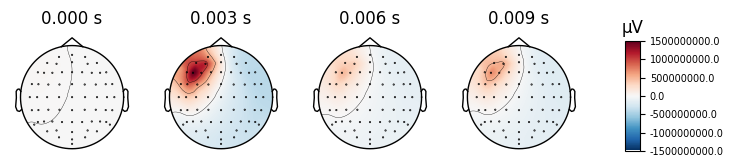

Using control points [0.000591   0.00106997 0.0148092 ]
Using control points [1.84739047e-11 9.88167800e-11 3.56812026e-09]
Using control points [0.00251259 0.00466055 0.03726087]


In [1036]:
%matplotlib qt
stc_ = stc.copy()
if len(x_hat.shape) == 1:
    stc_.data[:, 0] = x_hat / abs(x_hat).max()
    eeg = leadfield @ x_hat
    evoked = mne.EvokedArray(eeg[:, np.newaxis], info)


else:
    stc_.data = x_hat
    stc_.data /= abs(stc_.data).max()
    
    eeg = leadfield @ x_hat
    evoked = mne.EvokedArray(eeg, info)

brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Estimation', 'title',
               font_size=14)

evoked.plot_topomap()